# Прогнозирование кол-ва анестезий в зависимости от коечного фонда ЛПУ


In [79]:
import numpy as np
import pandas as pd
from pandas import read_csv, DataFrame
from itertools import combinations
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu 
import seaborn as sn
import matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score,r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVR
import optuna 
from optuna.samplers import TPESampler
import os
from collections import Counter
import cufflinks as cf

%matplotlib inline
init_notebook_mode(connected = True)
cf.go_offline()

pd.set_option('display.max_rows', 50) # выведем больше строк
pd.set_option('display.max_columns', 50) # выведем больше колонок

from matplotlib import pyplot as plt
# создадим функцию вычисляющую метрики
def print_regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred) # MAE (Mean Absolute Error, Средняя Абсолютная Ошибка) 
    mse = mean_squared_error(y_true, y_pred) # Средняя квадратическая ошибка
    rmse = np.sqrt(mse) # квадратный корень из MSE
    print(f'MAE = {mae:.2f}, MSE = {mse:.2f}, RMSE = {rmse:.2f}')


In [2]:
# загружаем исходные данные из csv файла
data = pd.read_csv('D:\Aston\Pyton\skill\sensus4.csv',encoding='UTF-8', delimiter=";")
# выводим первые 10 строк
data.head(10)

,Названия строк,Test,01._Аналгоседация,ФО_Москва,Тип поселения,Подчинение,ТПГГ_Стационарная МП_2016,01_Неуточненные данные,02_аллергологические для взрослых,03_аллергологические для детей,04_для беременных и рожениц (кроме патологии беременности),05_для патологии беременности,06_гинекологические для взрослых,07_гинекологические для детей,08_гастроэнтерологические для взрослых,09_гастроэнтерологические для детей,10_гематологические для взрослых,11_гематологические для детей,12_геронтологические,13_дерматологические для взрослых,14_дерматологические для детей,15_венерологические для взрослых,16_венерологические для детей,17_инфекционные для взрослых,18_инфекционные для детей,...,69_хирургии сосудистой,70_хирургические гнойные для взрослых,71_хирургические гнойные для детей,72_хирургии челюстно-лицевой,73_стоматологические для детей,74_эндокринологические для взрослых,75_эндокринологические для детей,76_прочие койки для взрослых,77_прочие койки для детей,Общий итог,02_аллергологические,04_гинекологические,08_гастроэнтерологические,10_гематологические,19_кардиологические,22_неврологические,24_нефрологические,26_онкологические,28_оториноларингологические,30_офтальмологические,37_психиатрические,40_пульмонологические,51_терапевтические_педиатрические,53_травматологические_ортопедичиские,61_хирургические
0,36001,1,60848.0,Центральный федеральный округ,городской,Региональное,10961,0,0,0,90,150,120,0,40,0,74,0,0,0,0,0,0,0,0,...,70,30,0,70,0,45,0,0,0,1850,0,360,40,74,115,115,40,30,80,0,0,40,30,90,625
1,23105,1,48761.0,Южный федеральный округ,городской,Региональное,30196,0,1,0,0,0,67,0,35,0,0,0,0,0,0,0,0,0,0,...,62,36,0,15,0,41,0,0,0,1757,1,67,35,0,159,87,60,157,0,77,0,34,26,170,559
2,77108,1,33874.0,Москва г.,городской,Федеральное,122306,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,364,0,0,0,0,0,0,0,0,0,364,0,0,0,0,0
3,77017,1,29316.0,Москва г.,городской,Региональное,122306,0,0,0,110,60,60,0,0,0,0,0,0,0,0,0,0,0,0,...,30,60,0,0,0,0,0,0,0,1345,0,230,0,0,160,120,30,0,0,135,0,0,110,75,425
4,77042,1,29304.0,Москва г.,городской,Региональное,122306,0,0,0,170,30,85,0,0,0,0,0,0,0,0,0,0,0,0,...,10,40,0,0,0,80,0,0,0,1353,0,285,0,0,98,154,0,0,40,60,60,0,106,125,400
5,23018,1,27421.0,Южный федеральный округ,городской,Региональное,30196,0,0,0,164,113,125,0,62,0,0,0,0,0,0,0,0,0,0,...,20,0,0,0,0,60,0,0,0,1366,0,402,62,0,80,123,3,65,0,0,0,45,97,0,357
6,77060,1,26293.0,Москва г.,городской,Региональное,122306,0,0,5,0,0,0,41,0,58,0,85,0,0,0,0,0,0,41,...,0,0,21,0,20,0,41,0,0,1032,5,41,58,85,15,71,10,135,49,45,0,19,182,31,146
7,77371,1,26222.0,Москва г.,городской,Федеральное,122306,0,0,0,83,73,73,0,223,40,34,0,0,92,0,0,0,0,0,...,45,40,0,38,0,70,20,0,0,3109,0,229,263,34,195,210,52,114,93,0,196,124,249,70,516
8,66099,1,25968.0,Уральский федеральный округ,городской,Региональное,25844,0,1,0,0,0,35,0,35,0,48,0,0,0,0,0,0,0,0,...,35,0,0,15,0,20,0,0,0,1050,1,35,35,48,70,57,59,0,15,70,0,12,20,30,500
9,77013,1,25956.0,Москва г.,городской,Региональное,122306,0,0,0,95,40,58,0,0,0,0,0,0,0,0,0,0,0,0,...,78,0,0,50,0,5,0,0,0,1004,0,193,0,0,48,80,10,20,60,40,56,5,20,100,332


In [3]:
# выводим информацию о типах данных в нашем df
data.dtypes.value_counts()
# количественные данные (целые)- количество коек определеннного пофиля в ЛПУ и объем финансирования на стационарную помощь в регионе на основе ТПГГ
# категориальные - подчиненность ЛПУ, федеральные округа, тип поселения
# количественные данные (вещественные)- число анестезий определенного вида, зависимая переменная

int64      96
object      3
float64     1
dtype: int64

In [4]:
# в data_test отбираем ЛПУ, у которых есть информация об анестезиях
data_test=data[data.Test==1]
# проверяем информацию о пропусках в данных
data_test.isnull().sum().sort_values(ascending=False)


61_хирургические                        0
30_офтальмологические для взрослых      0
20_кардиологические для детей           0
21_наркологические                      0
22_неврологические для взрослых         0
                                       ..
63_хирургические для детей              0
64_нейрохирургические для взрослых      0
65_нейрохирургические для детей         0
66_хирургии торакальной для взрослых    0
Названия строк                          0
Length: 100, dtype: int64

In [5]:
#Пропущенные значения переменной  заменим медианным значением
#data_test['название переменной'] = data_test.apply(lambda x: median if pd.isnull(x['название переменной']) else x['название переменной'], axis =  1)

In [6]:
# Зависимость числа анестезий от ФО  визуализация данных с помощью Plotly
data_test.pivot(columns='ФО_Москва', values='01._Аналгоседация').iplot(
        kind='box',
        yTitle='Анестезии',
        title='Зависимость числа анестезий от ФО')

In [7]:
# Зависимость числа анестезий от типа поселения визуализация данных с помощью Plotly
data_test.pivot(columns='Тип поселения', values='01._Аналгоседация').iplot(
        kind='box',
        yTitle='Анестезии',
        title='Зависимость числа анестезий от типа поселения')

In [8]:
# Зависимость числа анестезий от подчинения ЛПУ визуализация данных с помощью Plotly
data_test.pivot(columns='Подчинение', values='01._Аналгоседация').iplot(
        kind='box',
        yTitle='Анестезии',
        title='Зависимость числа анестезий от подчинения ЛПУ')


In [9]:
# Для категориальных признаков с помощью t-test выявляем наличие значимых различия в числе анестезий в различных группах      
# Отбираем качетвенные признаки
data_test_nominal=data_test.select_dtypes(include = ['object'])
# Функция для проверки взаимосвязи между категориямии и кол-вом анестезий на основе t-test. 
# Заданная значимость 0,05 делится на число комбинаций признаков в группе- поправку Бонферони 
def get_stat_dif(column):
    cols = data_test_nominal.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(data_test.loc[data_test.loc[:, column] == comb[0], '01._Аналгоседация'], 
                        data_test.loc[data_test.loc[:, column] == comb[1], '01._Аналгоседация']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column, comb)
        else:
            print('Не найдены статистически значимые различия для колонки', column, comb)   
# Запускаем функцию для всех качественных признаков
for col in data_test_nominal.columns.tolist():
    get_stat_dif(col)


Не найдены статистически значимые различия для колонки ФО_Москва ('Приволжский федеральный округ', 'Сибирский федеральный округ')
Не найдены статистически значимые различия для колонки ФО_Москва ('Приволжский федеральный округ', 'Южный федеральный округ')
Не найдены статистически значимые различия для колонки ФО_Москва ('Приволжский федеральный округ', 'Северо-Западный федеральный округ')
Не найдены статистически значимые различия для колонки ФО_Москва ('Приволжский федеральный округ', 'Центральный федеральный округ')
Не найдены статистически значимые различия для колонки ФО_Москва ('Приволжский федеральный округ', 'Северо-Кавказский федеральный округ')
Не найдены статистически значимые различия для колонки ФО_Москва ('Приволжский федеральный округ', 'Уральский федеральный округ')
Найдены статистически значимые различия для колонки ФО_Москва ('Приволжский федеральный округ', 'Москва г.')
Не найдены статистически значимые различия для колонки ФО_Москва ('Приволжский федеральный округ', 

In [10]:
# Добавляем переменную выделяющую Москву, как отдельную территорию
data_test['ФО_or_Москва'] = np.where(data_test['ФО_Москва'].str.contains('округ'), 1, 0)

In [11]:
# Создание фиктивных переменных с 0 и 1 для каждого типа поселения и вида подчинения ЛПУ
data_test=pd.get_dummies(data_test, columns=['Тип поселения','Подчинение'], prefix=['Тип поселения','Подчинение'])

In [12]:
# Выводим 10 строк обновленного df
data_test.head(10)

,Названия строк,Test,01._Аналгоседация,ФО_Москва,ТПГГ_Стационарная МП_2016,01_Неуточненные данные,02_аллергологические для взрослых,03_аллергологические для детей,04_для беременных и рожениц (кроме патологии беременности),05_для патологии беременности,06_гинекологические для взрослых,07_гинекологические для детей,08_гастроэнтерологические для взрослых,09_гастроэнтерологические для детей,10_гематологические для взрослых,11_гематологические для детей,12_геронтологические,13_дерматологические для взрослых,14_дерматологические для детей,15_венерологические для взрослых,16_венерологические для детей,17_инфекционные для взрослых,18_инфекционные для детей,19_кардиологические для взрослых,20_кардиологические для детей,...,76_прочие койки для взрослых,77_прочие койки для детей,Общий итог,02_аллергологические,04_гинекологические,08_гастроэнтерологические,10_гематологические,19_кардиологические,22_неврологические,24_нефрологические,26_онкологические,28_оториноларингологические,30_офтальмологические,37_психиатрические,40_пульмонологические,51_терапевтические_педиатрические,53_травматологические_ортопедичиские,61_хирургические,ФО_or_Москва,Тип поселения_городской,Тип поселения_сельский,Подчинение_Муниципальное,Подчинение_Региональное,Подчинение_Субрегиональное,Подчинение_Федеральное
0,36001,1,60848.0,Центральный федеральный округ,10961,0,0,0,90,150,120,0,40,0,74,0,0,0,0,0,0,0,0,115,0,...,0,0,1850,0,360,40,74,115,115,40,30,80,0,0,40,30,90,625,1,1,0,0,1,0,0
1,23105,1,48761.0,Южный федеральный округ,30196,0,1,0,0,0,67,0,35,0,0,0,0,0,0,0,0,0,0,159,0,...,0,0,1757,1,67,35,0,159,87,60,157,0,77,0,34,26,170,559,1,1,0,0,1,0,0
2,77108,1,33874.0,Москва г.,122306,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,364,0,0,0,0,0,0,0,0,0,364,0,0,0,0,0,0,1,0,0,0,0,1
3,77017,1,29316.0,Москва г.,122306,0,0,0,110,60,60,0,0,0,0,0,0,0,0,0,0,0,0,160,0,...,0,0,1345,0,230,0,0,160,120,30,0,0,135,0,0,110,75,425,0,1,0,0,1,0,0
4,77042,1,29304.0,Москва г.,122306,0,0,0,170,30,85,0,0,0,0,0,0,0,0,0,0,0,0,98,0,...,0,0,1353,0,285,0,0,98,154,0,0,40,60,60,0,106,125,400,0,1,0,0,1,0,0
5,23018,1,27421.0,Южный федеральный округ,30196,0,0,0,164,113,125,0,62,0,0,0,0,0,0,0,0,0,0,80,0,...,0,0,1366,0,402,62,0,80,123,3,65,0,0,0,45,97,0,357,1,1,0,0,1,0,0
6,77060,1,26293.0,Москва г.,122306,0,0,5,0,0,0,41,0,58,0,85,0,0,0,0,0,0,41,0,15,...,0,0,1032,5,41,58,85,15,71,10,135,49,45,0,19,182,31,146,0,1,0,0,1,0,0
7,77371,1,26222.0,Москва г.,122306,0,0,0,83,73,73,0,223,40,34,0,0,92,0,0,0,0,0,195,0,...,0,0,3109,0,229,263,34,195,210,52,114,93,0,196,124,249,70,516,0,1,0,0,0,0,1
8,66099,1,25968.0,Уральский федеральный округ,25844,0,1,0,0,0,35,0,35,0,48,0,0,0,0,0,0,0,0,70,0,...,0,0,1050,1,35,35,48,70,57,59,0,15,70,0,12,20,30,500,1,1,0,0,1,0,0
9,77013,1,25956.0,Москва г.,122306,0,0,0,95,40,58,0,0,0,0,0,0,0,0,0,0,0,0,48,0,...,0,0,1004,0,193,0,0,48,80,10,20,60,40,56,5,20,100,332,0,1,0,0,1,0,0


In [13]:
# Добавляем столбец "ФО_Москва_freq_enc" с частотой встречаемости каждого ФО и Москвы в выборке
freq_enc = data_test['ФО_Москва'].value_counts(normalize=True)
data_test["ФО_Москва_freq_enc"] = data_test['ФО_Москва'].map(freq_enc)
# Выводим 10 строк обновленного df, столбцы "ФО_Москва", "ФО_Москва_freq_enc"
data_test[["ФО_Москва", "ФО_Москва_freq_enc"]].head(10)

,ФО_Москва,ФО_Москва_freq_enc
0,Центральный федеральный округ,0.104681
1,Южный федеральный округ,0.124837
2,Москва г.,0.054616
3,Москва г.,0.054616
4,Москва г.,0.054616
5,Южный федеральный округ,0.124837
6,Москва г.,0.054616
7,Москва г.,0.054616
8,Уральский федеральный округ,0.069571
9,Москва г.,0.054616


In [14]:
# Дополнительная проверка с помощью непараметрического метода Манни-Уитни на выявление различей между Москвой и и "не Москвой"
mannwhitneyu(data_test[data_test['ФО_Москва']=='Москва г.']['01._Аналгоседация'], data_test[data_test['ФО_Москва']!='Москва г.']['01._Аналгоседация'],alternative='two-sided')

MannwhitneyuResult(statistic=102749.5, pvalue=6.187936746800537e-26)

In [15]:
# Дополнительная проверка с помощью непараметрического метода Манни-Уитни на выявление различей между региональными ЛПУ и не региональными ЛПУ
mannwhitneyu(data_test[data_test['Подчинение_Региональное']==1]['01._Аналгоседация'], data_test[data_test['Подчинение_Региональное']!=1]['01._Аналгоседация'],alternative='two-sided')

MannwhitneyuResult(statistic=460359.5, pvalue=3.8650506728764504e-89)

In [16]:
# Дополнительная проверка с помощью непараметрического метода Манни-Уитни на выявление различей между городскими и сельскими ЛПУ
mannwhitneyu(data_test[data_test['Тип поселения_городской']==1]['01._Аналгоседация'], data_test[data_test['Тип поселения_городской']!=1]['01._Аналгоседация'],alternative='two-sided')

MannwhitneyuResult(statistic=454179.0, pvalue=1.863132225136483e-117)

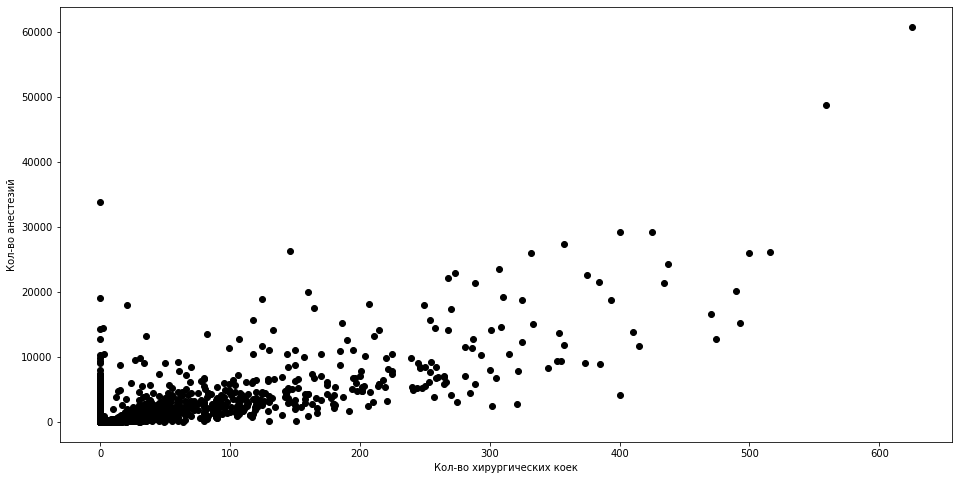

In [18]:
# График зависимости анестезий от количества коек хирургического профиля
plt.figure(figsize=(16, 8))
plt.scatter(
    data_test['61_хирургические'],
    data_test['01._Аналгоседация'],
    c='black'
)
plt.xlabel("Кол-во хирургических коек")
plt.ylabel("Кол-во анестезий")
plt.show()

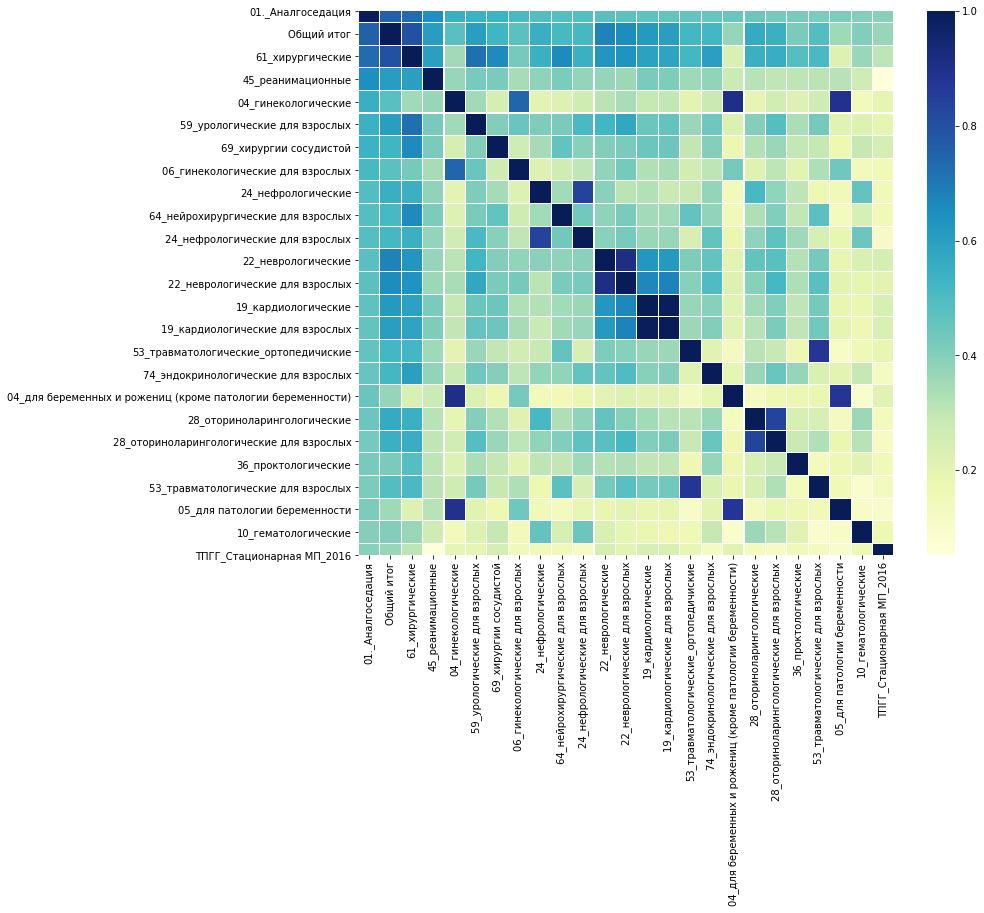

In [19]:
# Построим корреляционную матрицу для нашего df
# k: количество переменных для тепловой карты
# Исключим лишние переменные 'Названия строк' и 'Test'
data_corr = data_test.drop(['Названия строк', 'Test'], axis = 1)
corr_matrix_25 = data_corr.corr()
# k: количество переменных для тепловой карты - отбираем top 25 переменных наиболее сильно коррелирующих снашей зависимой переменной
k = 25 
cols = corr_matrix_25.nlargest(k, '01._Аналгоседация')['01._Аналгоседация'].index
cm = np.corrcoef(data_corr[cols].values.T)
f, ax = plt.subplots(figsize =(12, 10))
sn.heatmap(cm, ax = ax, cmap ="YlGnBu",
            linewidths = 0.1, yticklabels = cols.values, 
                              xticklabels = cols.values)

In [20]:
# top 25 переменных
cols

Index(['01._Аналгоседация', 'Общий итог', '61_хирургические',
       '45_реанимационные', '04_гинекологические',
       '59_урологические для взрослых', '69_хирургии сосудистой',
       '06_гинекологические для взрослых', '24_нефрологические',
       '64_нейрохирургические для взрослых', '24_нефрологические для взрослых',
       '22_неврологические', '22_неврологические для взрослых',
       '19_кардиологические', '19_кардиологические для взрослых',
       '53_травматологические_ортопедичиские',
       '74_эндокринологические для взрослых',
       '04_для беременных и рожениц (кроме патологии беременности)',
       '28_оториноларингологические',
       '28_оториноларингологические для взрослых', '36_проктологические',
       '53_травматологические для взрослых', '05_для патологии беременности',
       '10_гематологические', 'ТПГГ_Стационарная МП_2016'],
      dtype='object')

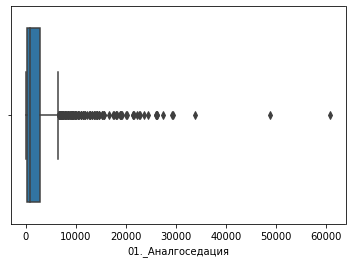

In [21]:
# Для оценки выбросов строим "ящик с усами" для показателя анестезии
ax = sn.boxplot(x=data_test['01._Аналгоседация'])

In [22]:
# Описательная статистика для показателя анестезии 
data_test['01._Аналгоседация'].describe()

count     1538.000000
mean      2397.832250
std       4341.352057
min          2.000000
25%        270.000000
50%        780.000000
75%       2761.000000
max      60848.000000
Name: 01._Аналгоседация, dtype: float64

25-й перцентиль: 270.0, 75-й перцентиль: 2761.0, IQR: 2491.0,  Границы выбросов: [-3466.5, 6497.5].


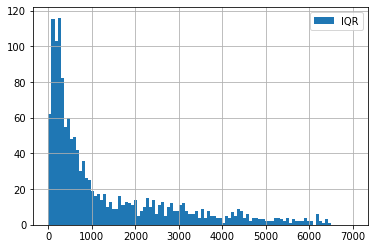

In [24]:
# Оцениваем межквартильный размах (IQR), чтобы в дальнейщем исключить значения, превосходящие (3 квартиль + 1.5*IQR)
IQR = data_test['01._Аналгоседация'].quantile(0.75) - data_test['01._Аналгоседация'].quantile(0.25)
perc25 = data_test['01._Аналгоседация'].quantile(0.25)
perc75 = data_test['01._Аналгоседация'].quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
data_test['01._Аналгоседация'].loc[data_test['01._Аналгоседация'].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 100, range = (0, 7000), 
                                                                                             label = 'IQR')
plt.legend();

In [25]:
#  Оставляем значения, непревосходящие (3 квартиль + 1.5*IQR)
data_test_norm=data_test.loc[data_test['01._Аналгоседация'].between(0, 6500)]
# Описательная статистика для показателя анестезии 
data_test_norm['01._Аналгоседация'].describe()

count    1398.000000
mean     1335.715308
std      1503.698294
min         2.000000
25%       241.000000
50%       644.000000
75%      2016.500000
max      6480.000000
Name: 01._Аналгоседация, dtype: float64

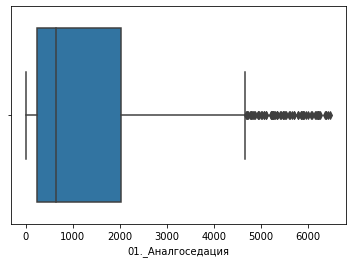

In [26]:
# Строим "ящик с усами" для показателя анестезии
# Выбросы убраны
ax = sn.boxplot(x=data_test_norm['01._Аналгоседация'])

In [40]:
# Убираем все лишние переменные из дальнейшего анализа
# Создаем массив независимых переменных и выделяем зависимую переменную
X, y = data_test_norm.drop([ 'Названия строк','ФО_Москва', 'Test', '01._Аналгоседация', '01_Неуточненные данные', '15_венерологические для взрослых', '14_дерматологические для детей' ,'16_венерологические для детей', '76_прочие койки для взрослых',  'Общий итог'], axis = 1) , data_test_norm['01._Аналгоседация']


In [41]:
# Разделяем на обучающую и тестовую выборку (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 2020)
# Масштабирование данных
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


In [48]:
# Зададим модели для обучения
models = [LinearRegression(), # метод наименьших квадратов
          LassoCV(), # Регрессия лассо использует регуляризацию L1, то есть взвешивает ошибки по их абсолютному значению. Некоторые коэффициенты могут стать 0
          RidgeCV(), # Гребневая регрессия использует регуляризацию L2, то есть ни один из коэффициентов не становится нулевым
          ElasticNetCV(), # ElasticNet стремится объединить лучшее из гребневой регрессии и регрессии лассо, комбинируя регуляризацию L1 и L2.
          DecisionTreeRegressor(),# Дерево решений
          RandomForestRegressor(), # случайный лес
          KNeighborsRegressor(n_neighbors=6), # метод ближайших соседей
          xgb.XGBRegressor(verbosity=0) # градиентный бустинг
         ]

In [157]:
#создаем временные структуры
TestModels = DataFrame()
tmp = {}
#для каждой модели из списка
for model in models:
#получаем имя модели
 m = str(model)
 tmp['Model'] = m[:m.index('(')]
 
#для каждого столбцам результирующего набора
#обучаем модель
 model.fit(X_train_scaled, y_train) 
 #вычисляем коэффициент детерминации
 tmp['R2_Y%s'%str(1)] = r2_score(y_train, model.predict(X_train_scaled))
 tmp['R2_Y%s'%str(2)] = r2_score(y_test, model.predict(X_test_scaled))
#записываем данные и итоговый DataFrame
 TestModels = TestModels.append([tmp])
 print(tmp['Model'])
 print_regression_metrics(y_train, model.predict(X_train_scaled))
 print_regression_metrics(y_test, model.predict(X_test_scaled))  
#делаем индекс по названию модели
TestModels.set_index('Model', inplace=True)

LinearRegression
MAE = 409.90, MSE = 412394.24, RMSE = 642.18
MAE = 504.12, MSE = 644793.73, RMSE = 802.99
LassoCV
MAE = 446.41, MSE = 481996.51, RMSE = 694.26
MAE = 472.72, MSE = 523836.91, RMSE = 723.77
RidgeCV
MAE = 409.96, MSE = 412552.12, RMSE = 642.30
MAE = 502.10, MSE = 636123.95, RMSE = 797.57
ElasticNetCV
MAE = 477.90, MSE = 520281.46, RMSE = 721.31
MAE = 508.98, MSE = 591471.07, RMSE = 769.07
DecisionTreeRegressor
MAE = 1.37, MSE = 755.74, RMSE = 27.49
MAE = 604.26, MSE = 976451.20, RMSE = 988.16
RandomForestRegressor
MAE = 165.36, MSE = 73743.91, RMSE = 271.56
MAE = 442.53, MSE = 471590.47, RMSE = 686.72
KNeighborsRegressor
MAE = 465.08, MSE = 610905.97, RMSE = 781.60
MAE = 565.11, MSE = 845826.47, RMSE = 919.69
XGBRegressor
MAE = 49.91, MSE = 6847.07, RMSE = 82.75
MAE = 470.66, MSE = 515013.70, RMSE = 717.64


In [158]:
#вычисленные коэффициенты детерминации для тренировочной и тестовой выбоки
TestModels

,R2_Y1,R2_Y2
Model,,
LinearRegression,0.815221,0.727913
LassoCV,0.784034,0.778954
RidgeCV,0.815150,0.731572
ElasticNetCV,0.766880,0.750414
DecisionTreeRegressor,0.999661,0.587963
RandomForestRegressor,0.966958,0.801001
KNeighborsRegressor,0.726274,0.643083
XGBRegressor,0.996932,0.782677


In [189]:
# Отсортируем модели по убыванию результата на тестовой выборке
TestModels_sort = TestModels.sort_values("R2_Y2", axis = 0, ascending = False)
TestModels_sort

,R2_Y1,R2_Y2
Model,,
RandomForestRegressor,0.966958,0.801001
XGBRegressor,0.996932,0.782677
LassoCV,0.784034,0.778954
ElasticNetCV,0.766880,0.750414
RidgeCV,0.815150,0.731572
LinearRegression,0.815221,0.727913
KNeighborsRegressor,0.726274,0.643083
DecisionTreeRegressor,0.999661,0.587963


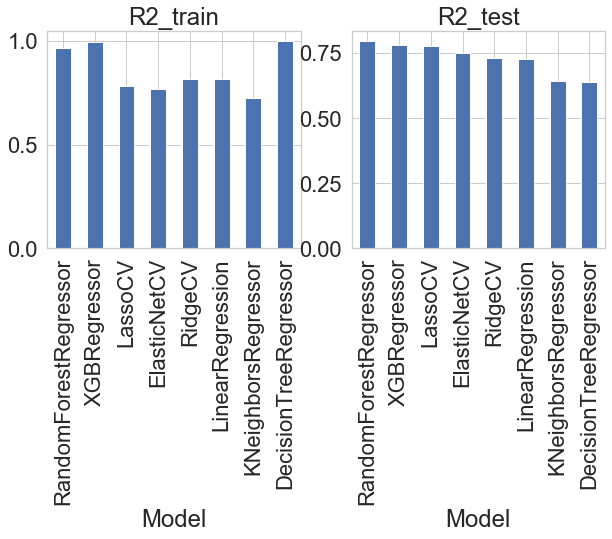

In [151]:
# Отобразим графически полученные результаты
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
TestModels_sort.R2_Y1.plot(ax=axes[0], kind='bar', title='R2_train')
TestModels_sort.R2_Y2.plot(ax=axes[1], kind='bar', title='R2_test')
# Лучший результат у RandomForestRegressor - 0,799

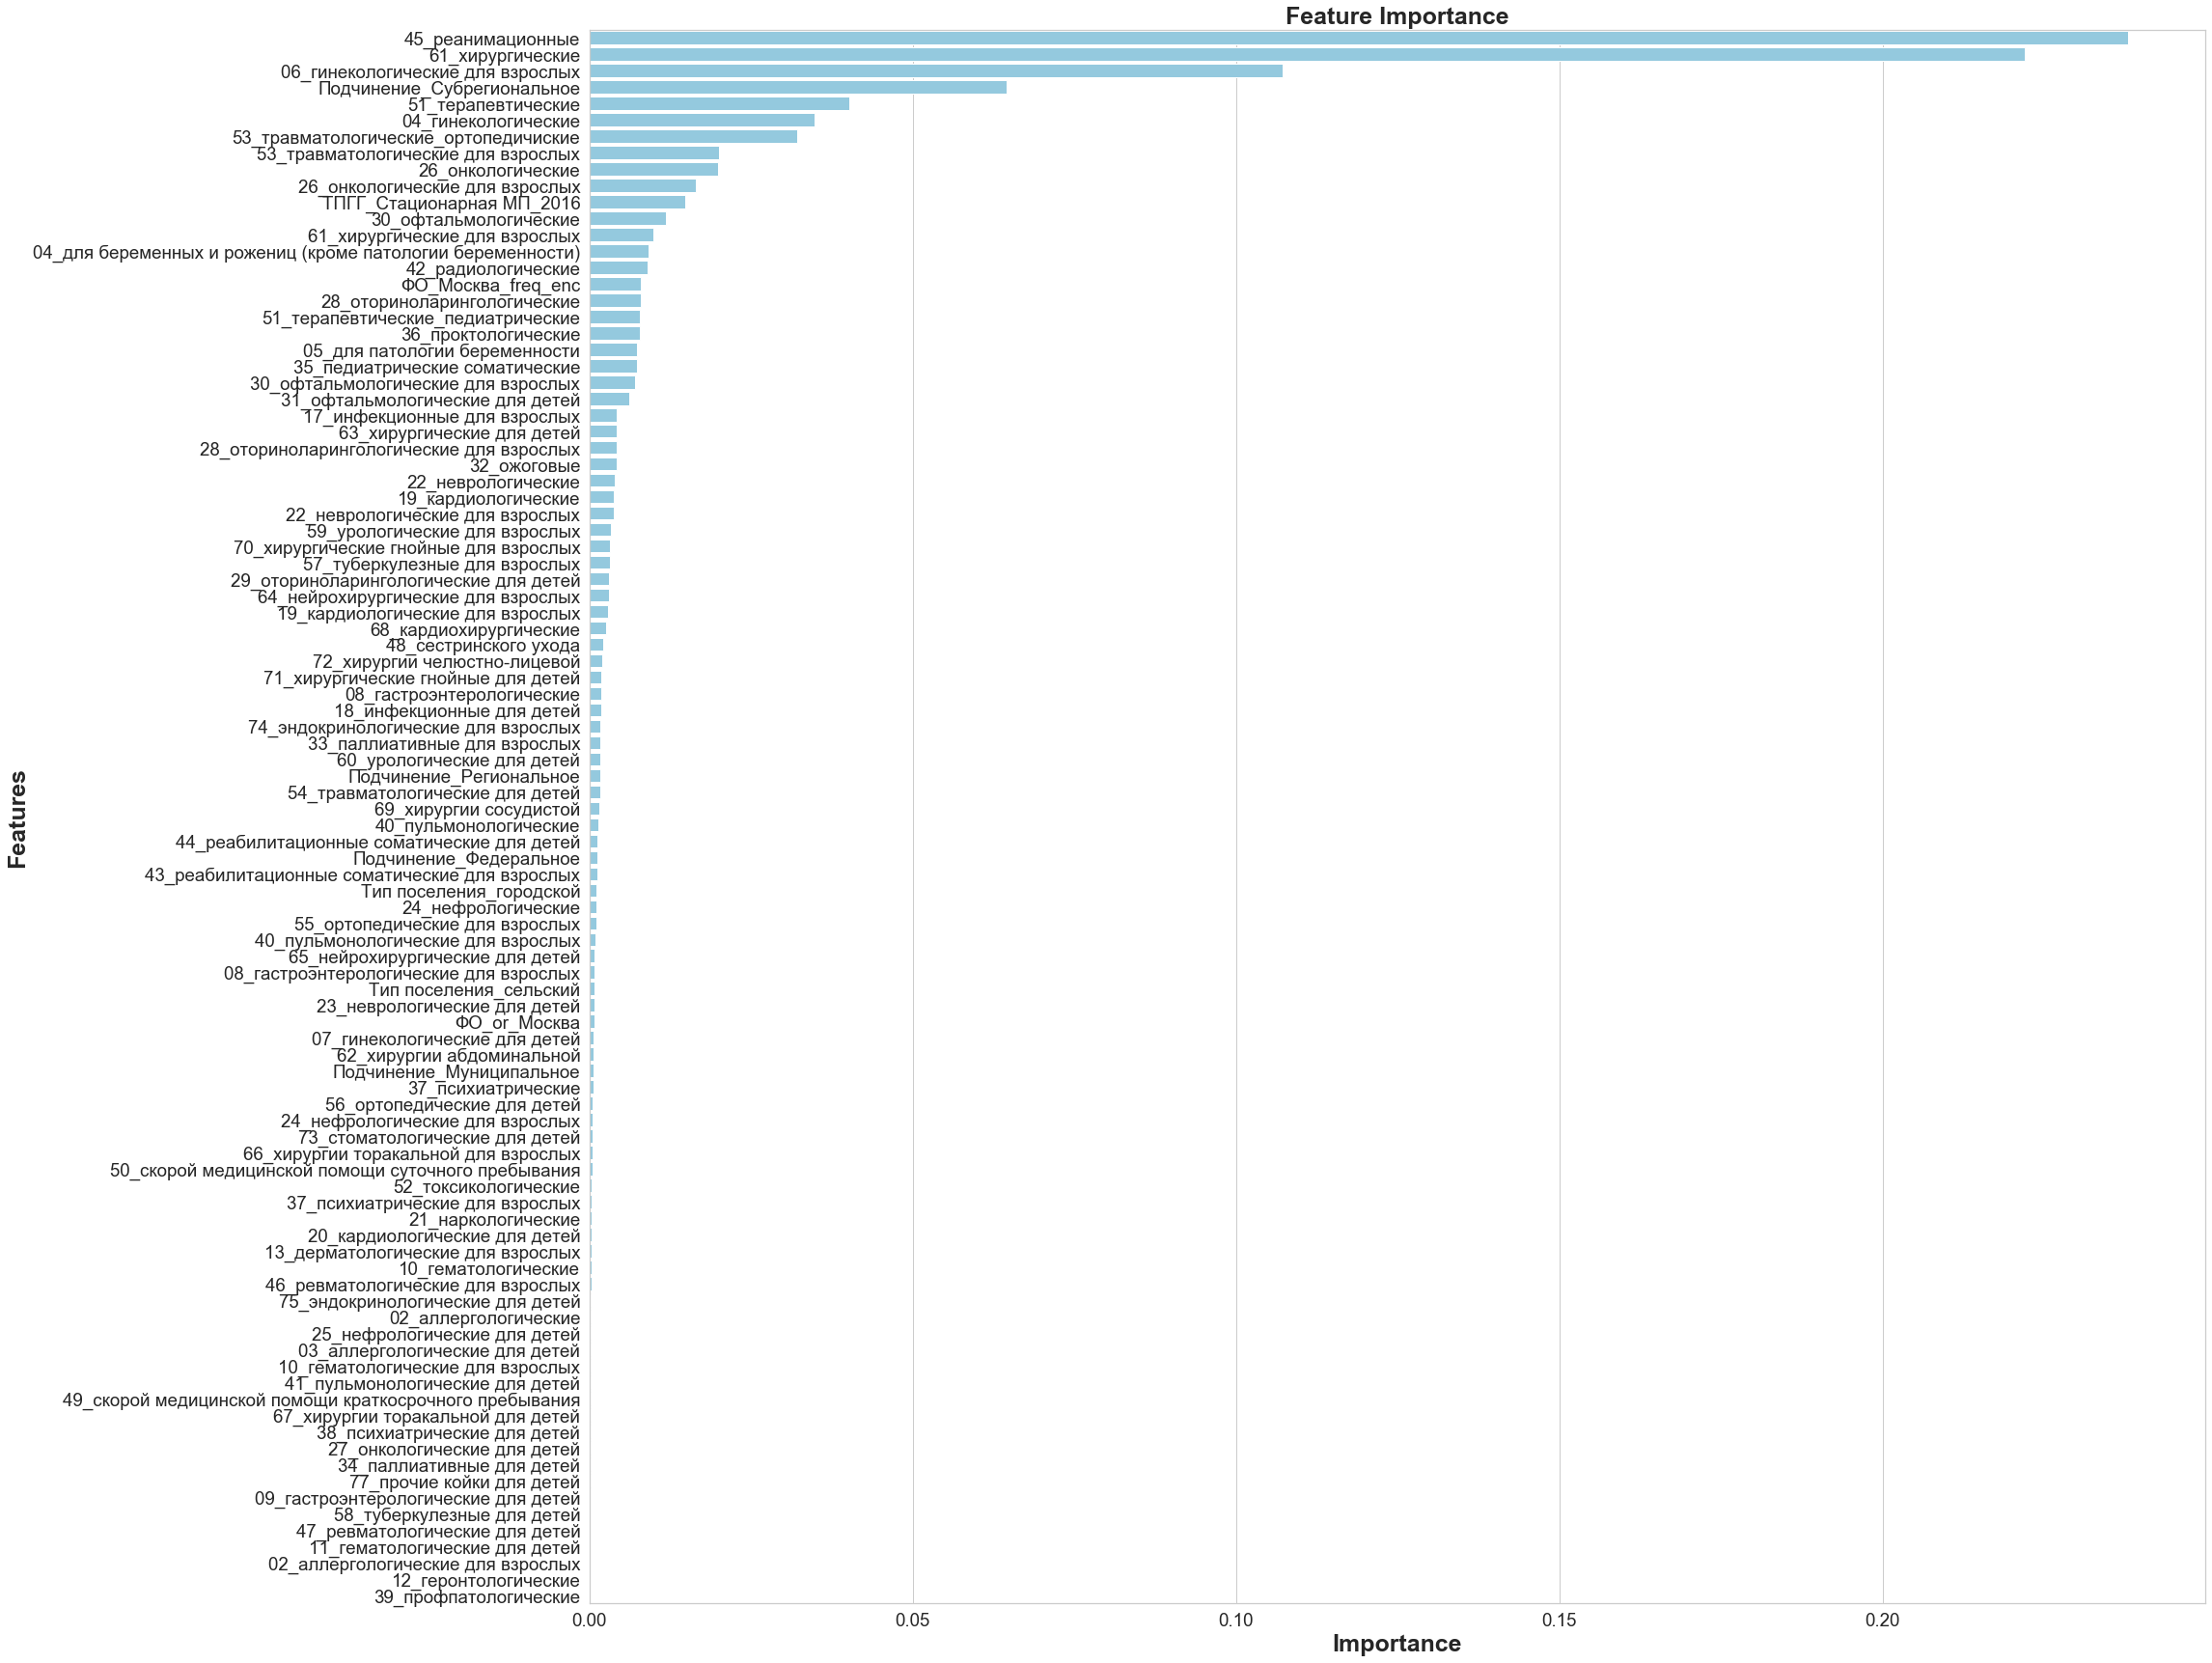

None

,Features,Gini-Importance
0,45_реанимационные,0.238009
1,61_хирургические,0.221976
2,06_гинекологические для взрослых,0.107289
3,Подчинение_Субрегиональное,0.064588
4,51_терапевтические,0.040129
5,04_гинекологические,0.034752
6,53_травматологические_ортопедичиские,0.032146
7,53_травматологические для взрослых,0.020078
8,26_онкологические,0.019930
9,26_онкологические для взрослых,0.016504


In [55]:
# Для RandomForestRegressor отобразим важность признаков
rfr_1 = RandomForestRegressor()
rfr_1.fit(X_train_scaled, y_train)
# Создадим df importances, содержащий инфориацию о важности каждого признака. Данные отсортированы по убыванию важности
feats = {}
for feature, importance in zip(X_train.columns, rfr_1.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sn.set(font_scale = 5)
sn.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,30)
sn.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
# Выведем наиболее важные 20 признаков
display(importances.head(20))


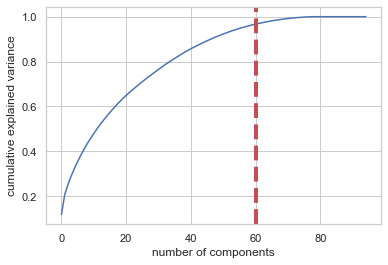

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.119023,0.119023
1,0.206558,0.087535
2,0.251276,0.044717
3,0.289743,0.038468
4,0.323448,0.033705
...,...,...
55,0.947894,0.004501
56,0.952025,0.004131
57,0.956019,0.003994
58,0.959931,0.003912


In [57]:
# Применяется уменьшение размерности пространства признаков с помощью метода главных компонент 
# Используя PCA, можно изучить кумулятивную выборочную дисперсию этих признаков для того,
# чтобы понять то, какие признаки объясняют большую часть дисперсии в данных.
pca_test = PCA(n_components=95)
pca_test.fit(X_train_scaled)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
# После того, как число используемых компонент превышает 60, рост их количества не очень сильно повышает объяснённую дисперсию
plt.axvline(linewidth=4, color='r', linestyle = '--', x=60, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(60))

In [69]:
# Запишем искусственно созданные наборы данных «пониженной размерности» в X_train_scaled_pca и в X_test_scaled_pca.
pca = PCA(n_components=60)
pca.fit(X_train_scaled)
X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

In [70]:
# Каждая компонента — это линейная комбинация исходных переменных с соответствующими «весами». Мы можем видеть эти «веса» для каждой компоненты, создав датафрейм.
# Мы можем видеть эти «веса» для каждой компоненты, создав датафрейм.
pca_dims = []
for x in range(0, len(pca_df)):
    pca_dims.append('PCA Component {}'.format(x))
pca_test_df = pd.DataFrame(pca_test.components_, index=pca_dims)
pca_test_df.head(60).T

,PCA Component 0,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,PCA Component 5,PCA Component 6,PCA Component 7,PCA Component 8,PCA Component 9,PCA Component 10,PCA Component 11,PCA Component 12,PCA Component 13,PCA Component 14,PCA Component 15,PCA Component 16,PCA Component 17,PCA Component 18,PCA Component 19,PCA Component 20,PCA Component 21,PCA Component 22,PCA Component 23,PCA Component 24,...,PCA Component 35,PCA Component 36,PCA Component 37,PCA Component 38,PCA Component 39,PCA Component 40,PCA Component 41,PCA Component 42,PCA Component 43,PCA Component 44,PCA Component 45,PCA Component 46,PCA Component 47,PCA Component 48,PCA Component 49,PCA Component 50,PCA Component 51,PCA Component 52,PCA Component 53,PCA Component 54,PCA Component 55,PCA Component 56,PCA Component 57,PCA Component 58,PCA Component 59
0,0.065929,-0.021440,0.100861,-0.033492,0.138790,0.426588,-0.116658,-0.010749,0.165066,-0.060221,-0.031855,0.029008,0.088337,0.052328,0.033961,-0.015306,-0.051774,0.084869,0.013420,-0.064878,-0.012778,0.033515,-0.001386,0.018662,-0.041319,...,-0.006768,0.055646,0.051990,0.030647,-0.016094,-0.083369,-0.033739,-0.050292,-0.102353,-0.128691,0.028097,-0.061729,0.024448,-0.103351,-0.037399,0.028975,0.095939,0.029297,-0.049080,0.055541,0.079764,-0.068554,0.028852,0.013243,0.045682
1,0.027966,-0.030186,0.074719,-0.039589,-0.067486,0.021612,-0.115442,-0.045828,-0.026907,0.127816,0.371185,0.145886,0.204522,-0.147859,0.000418,-0.072798,-0.220133,0.017424,0.127181,0.002915,-0.083035,0.051388,-0.103386,0.125716,0.055392,...,-0.077121,-0.057535,0.117539,0.057728,0.084188,-0.016132,-0.056432,-0.039464,0.118122,0.087974,-0.043334,0.169903,-0.082168,0.272612,0.138104,0.152299,-0.012280,-0.123392,-0.064077,-0.007563,0.288922,-0.264386,-0.072580,0.090164,-0.080727
2,0.113569,0.107026,0.010350,-0.011587,-0.183936,0.067237,-0.063106,-0.071211,-0.090560,-0.028207,0.247780,0.106721,0.017436,-0.003180,-0.084844,0.022201,0.255089,-0.058363,-0.071980,0.075431,-0.047046,0.013740,0.265304,-0.024666,-0.127336,...,-0.022258,0.020377,-0.087817,-0.044040,0.061721,-0.013717,0.041492,0.062246,-0.120929,-0.088884,-0.030627,-0.095858,-0.035341,-0.062767,-0.069868,-0.071666,0.053429,0.092252,0.017158,0.035930,-0.122207,0.114280,-0.005300,-0.001390,0.043171
3,0.019201,-0.049356,-0.175992,0.389052,-0.013205,-0.026803,-0.144111,-0.027149,0.099392,0.020083,-0.009831,-0.050639,0.064390,0.076315,0.020661,0.023232,-0.004179,0.037261,0.131199,-0.071640,0.010133,0.031612,-0.012028,0.014627,-0.001301,...,-0.021939,-0.019955,-0.011500,0.037480,-0.017994,-0.029144,-0.122015,-0.011040,-0.087897,0.112672,-0.140172,0.000257,0.035229,-0.000578,-0.000934,0.078162,-0.006966,-0.094368,0.067555,0.046072,-0.028595,0.082601,-0.008965,0.014467,0.044705
4,0.016854,-0.048149,-0.191039,0.363250,-0.019974,-0.040502,-0.138378,-0.043842,0.112220,0.011401,-0.016159,-0.050186,0.064905,0.088086,0.044065,0.010806,0.001892,0.018509,0.153586,-0.086438,-0.012063,0.061740,-0.012237,0.010194,-0.001289,...,0.012931,-0.040912,-0.085194,0.047995,-0.022553,-0.005764,-0.147414,0.043267,-0.093244,0.115852,-0.161978,0.025367,0.050066,0.009418,-0.017797,0.087137,-0.044762,-0.130821,0.033736,0.042429,-0.075551,0.011854,0.034690,0.012932,0.050033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.017486,-0.053357,-0.134218,0.016528,0.024550,0.054757,0.035972,-0.028869,0.092369,-0.099573,0.013573,0.109966,0.008171,0.024156,0.215212,-0.031275,0.051199,-0.108553,0.077144,0.135834,-0.091772,0.270105,-0.121075,-0.254831,-0.131379,...,0.053861,0.177644,0.220498,-0.218488,-0.031809,0.122222,-0.086771,-0.073195,-0.169670,-0.110709,0.128242,0.048647,0.152673,0.218694,-0.103244,-0.052404,0.004049,0.087142,-0.156101,-0.009967,0.030283,0.011346,0.063731,0.106033,0.049666
92,0.129948,-0.059698,0.145012,0.268446,0.014831,-0.048405,-0.0

In [89]:
# обучим базовую модель на новых переменных
rfr_2 = RandomForestRegressor()
rfr_2.fit(X_train_scaled_pca, y_train)
# R2 для обучающей и тестовой выборки
display(rfr_2.score(X_train_scaled_pca, y_train))
display(rfr_2.score(X_test_scaled_pca, y_test))

0.95388687741275

0.7137934309535354

In [72]:
# С помощью RandomizedSearchCV при значениях параметров n_iter = 100 и cv = 3, мы создали 300 RF-моделей, 
# случайно выбирая комбинации представленных выше гиперпараметров. 
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt', 'auto']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(rfr_2, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X_train_scaled_pca, y_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.3min finished


{'n_estimators': 700,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 7,
 'bootstrap': True}

In [74]:
# Отобразим 10 лучших моделей
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,700,2,2,auto,7,True,0.652095,1
1,600,18,7,sqrt,10,False,0.645139,2
2,400,18,7,sqrt,14,True,0.624021,3
3,1000,28,12,auto,15,True,0.623941,4
4,100,18,12,auto,11,True,0.622213,5
5,300,7,12,log2,14,False,0.616653,6
6,700,23,7,sqrt,5,False,0.616419,7
7,1000,44,2,auto,6,True,0.610243,8
8,800,18,12,sqrt,13,True,0.606247,9
9,800,12,7,log2,6,True,0.604229,10


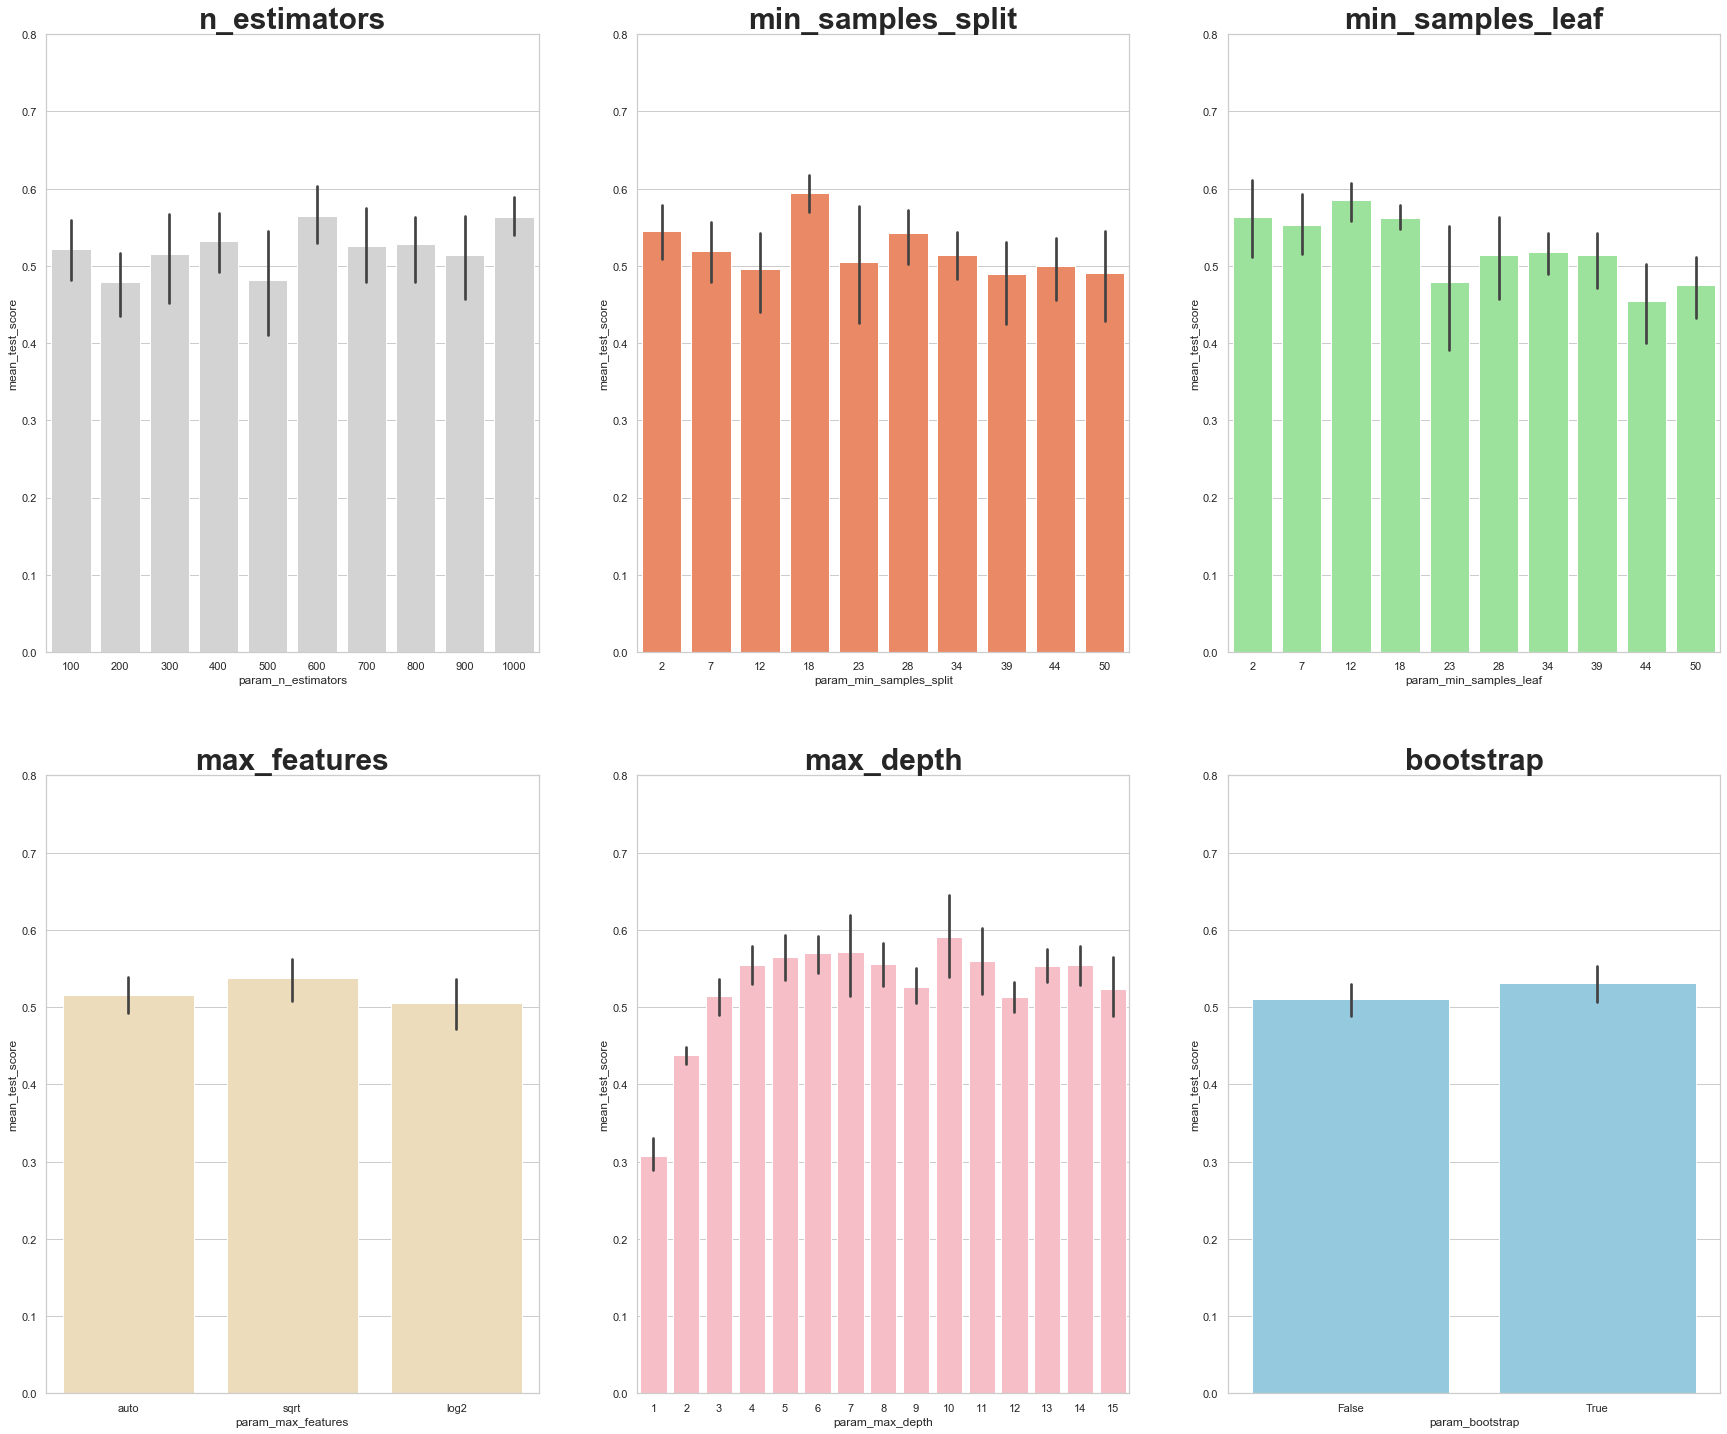

In [75]:
# Создадим столбчатые графики, на которых, по оси Х, расположены значения гиперпараметров,
# а по оси Y — средние значения, показываемые моделями. 
# Это позволит понять то, какие значения гиперпараметров, в среднем, лучше всего себя показывают.
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.0,.8]) 
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.0,.8])
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.0,.8])
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.0,.8])
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.0,.8])
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.0,.8])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()

In [94]:
# С помощью GridSearchCV перебираем всю сетку параметров 
n_estimators = [100, 700]
max_features =  ['auto']
max_depth = [7,10, None]
min_samples_split = [2, 18]
min_samples_leaf = [1, 2,18]
bootstrap = [True]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(rfr_2, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_train_scaled_pca, y_train)
rfr_3 = gs.best_estimator_
gs.best_params_
# {'bootstrap': False,
# 'max_depth': 10,
# 'max_features': 'sqrt',
# 'min_samples_leaf': 2,
# 'min_samples_split': 2,
# 'n_estimators': 700}

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  4.7min finished


{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [95]:
# Строим предсказание для каждой модели на основе проверочных данных
y_pred = rfr_1.predict(X_test_scaled)
y_pred_pca = rfr_2.predict(X_test_scaled_pca)
y_pred_gs = gs.best_estimator_.predict(X_test_scaled_pca)

In [159]:
# Оценим созданные модели на проверочных данных
display('Baseline Random Forest r2 score', r2_score(y_test, rfr_1.predict(X_test_scaled)))
display('Baseline Random Forest With PCA r2 score', r2_score(y_test, rfr_2.predict(X_test_scaled_pca)))
display('Hyperparameter Tuned Random Forest With PCA Reduced Dimensionality r2 score', r2_score(y_test, rfr_3.predict(X_test_scaled_pca)))

'Baseline Random Forest r2 score'

0.7942129133912791

'Baseline Random Forest With PCA r2 score'

0.7137934309535354

'Hyperparameter Tuned Random Forest With PCA Reduced Dimensionality r2 score'

0.7117255102440214

In [186]:
# Зададим значения гиперпараметров для RandomForestRegressor для поиска лучшей модели
def objective(trial):
   max_features = trial.suggest_categorical('max_features', ['log2', 'auto', 'sqrt'])
   bootstrap = trial.suggest_categorical('bootstrap', [True, False])
   max_depths = trial.suggest_int('max_depth', 1,15,1)
   n_estimators = trial.suggest_int('n_estimators', 100, 1000, 100)
   min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 18, 1)
   min_samples_split = trial.suggest_int('min_samples_split', 2, 23, 1) 
   reg = RandomForestRegressor(n_estimators=n_estimators,
                                 bootstrap=bootstrap,
                                 max_features=max_features,
                                 min_samples_leaf=min_samples_leaf,
                                 min_samples_split=min_samples_split,
                                 max_depth=max_depths, n_jobs=-1)
   
   reg.fit(X_train_scaled, y_train)
   reg.predict(X_test_scaled)

   score = reg.score(X_test_scaled, y_test)
 

   return score 

In [187]:

study_rfr = optuna.create_study(study_name="randomForest_optimization",
                            direction="maximize",
                            sampler=TPESampler())

[I 2021-07-11 09:57:33,609] A new study created in memory with name: randomForest_optimization


In [200]:
# Запустим поиск
study_rfr.optimize(objective, n_trials=5)

[I 2021-07-11 11:12:40,870] Trial 1000 finished with value: 0.80088546771151 and parameters: {'max_features': 'auto', 'bootstrap': True, 'max_depth': 13, 'n_estimators': 100, 'min_samples_leaf': 2, 'min_samples_split': 6}. Best is trial 547 with value: 0.8090829454166119.
[I 2021-07-11 11:12:41,698] Trial 1001 finished with value: 0.7933957437993182 and parameters: {'max_features': 'auto', 'bootstrap': True, 'max_depth': 9, 'n_estimators': 200, 'min_samples_leaf': 1, 'min_samples_split': 4}. Best is trial 547 with value: 0.8090829454166119.
[I 2021-07-11 11:12:42,141] Trial 1002 finished with value: 0.7841115783739483 and parameters: {'max_features': 'sqrt', 'bootstrap': True, 'max_depth': 15, 'n_estimators': 100, 'min_samples_leaf': 1, 'min_samples_split': 2}. Best is trial 547 with value: 0.8090829454166119.
[I 2021-07-11 11:12:42,847] Trial 1003 finished with value: 0.8004441430099535 and parameters: {'max_features': 'auto', 'bootstrap': True, 'max_depth': 13, 'n_estimators': 100, '

In [190]:
# Выведем параметры лучшей модели
print(study_rfr.best_params)

{'max_features': 'auto', 'bootstrap': True, 'max_depth': 13, 'n_estimators': 100, 'min_samples_leaf': 1, 'min_samples_split': 5}


In [191]:
print(study_rfr.best_value)

0.8090829454166119


In [107]:
# Зададим значения гиперпараметров для RandomForestRegressor для поиска лучшей модели для PCA
def objective(trial):
   max_features = trial.suggest_categorical('max_features', ['log2', 'auto', 'sqrt'])
   bootstrap = trial.suggest_categorical('bootstrap', [True, False])
   max_depths = trial.suggest_int('max_depth', 1,15,1)
   n_estimators = trial.suggest_int('n_estimators', 100, 1000, 100)
   min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 18, 1)
   min_samples_split = trial.suggest_int('min_samples_split', 2, 23, 1) 
   reg = RandomForestRegressor(n_estimators=n_estimators,
                                 bootstrap=bootstrap,
                                 max_features=max_features,
                                 min_samples_leaf=min_samples_leaf,
                                 min_samples_split=min_samples_split,
                                 max_depth=max_depths, n_jobs=-1)
   
   reg.fit(X_train_scaled_pca, y_train)
   reg.predict(X_test_scaled_pca)

   score = reg.score(X_test_scaled_pca, y_test)
 

   return score 

In [108]:

study_PCA = optuna.create_study(study_name="RandomForest_PCA_optimization",
                            direction="maximize",
                            sampler=TPESampler())

[I 2021-07-11 03:19:17,959] A new study created in memory with name: RandomForest_PCA_optimization


In [109]:
# Запустим поиск
study_PCA.optimize(objective, n_trials=100)

[I 2021-07-11 03:19:21,499] Trial 0 finished with value: 0.6757160170522375 and parameters: {'max_features': 'sqrt', 'bootstrap': True, 'max_depth': 12, 'n_estimators': 300, 'min_samples_leaf': 6, 'min_samples_split': 15}. Best is trial 0 with value: 0.6757160170522375.
[I 2021-07-11 03:19:22,379] Trial 1 finished with value: 0.5908435610015145 and parameters: {'max_features': 'log2', 'bootstrap': True, 'max_depth': 4, 'n_estimators': 500, 'min_samples_leaf': 14, 'min_samples_split': 21}. Best is trial 0 with value: 0.6757160170522375.
[I 2021-07-11 03:19:24,049] Trial 2 finished with value: 0.6433559746598914 and parameters: {'max_features': 'sqrt', 'bootstrap': True, 'max_depth': 5, 'n_estimators': 900, 'min_samples_leaf': 8, 'min_samples_split': 21}. Best is trial 0 with value: 0.6757160170522375.
[I 2021-07-11 03:19:24,676] Trial 3 finished with value: 0.44592580835767814 and parameters: {'max_features': 'log2', 'bootstrap': True, 'max_depth': 2, 'n_estimators': 300, 'min_samples_l

[I 2021-07-11 03:24:31,032] Trial 29 finished with value: 0.7246146274947614 and parameters: {'max_features': 'auto', 'bootstrap': True, 'max_depth': 14, 'n_estimators': 700, 'min_samples_leaf': 5, 'min_samples_split': 5}. Best is trial 16 with value: 0.7283661182192889.
[I 2021-07-11 03:24:44,703] Trial 30 finished with value: 0.7241411983018764 and parameters: {'max_features': 'auto', 'bootstrap': True, 'max_depth': 12, 'n_estimators': 900, 'min_samples_leaf': 7, 'min_samples_split': 10}. Best is trial 16 with value: 0.7283661182192889.
[I 2021-07-11 03:25:02,588] Trial 31 finished with value: 0.7280589818654897 and parameters: {'max_features': 'auto', 'bootstrap': True, 'max_depth': 13, 'n_estimators': 1000, 'min_samples_leaf': 4, 'min_samples_split': 5}. Best is trial 16 with value: 0.7283661182192889.
[I 2021-07-11 03:25:19,650] Trial 32 finished with value: 0.7263061985041579 and parameters: {'max_features': 'auto', 'bootstrap': True, 'max_depth': 14, 'n_estimators': 1000, 'min_s

[I 2021-07-11 03:30:39,220] Trial 58 finished with value: 0.7210730344123097 and parameters: {'max_features': 'auto', 'bootstrap': True, 'max_depth': 15, 'n_estimators': 1000, 'min_samples_leaf': 1, 'min_samples_split': 13}. Best is trial 16 with value: 0.7283661182192889.
[I 2021-07-11 03:31:06,470] Trial 59 finished with value: 0.5422339381067001 and parameters: {'max_features': 'auto', 'bootstrap': False, 'max_depth': 13, 'n_estimators': 900, 'min_samples_leaf': 2, 'min_samples_split': 3}. Best is trial 16 with value: 0.7283661182192889.
[I 2021-07-11 03:31:21,872] Trial 60 finished with value: 0.7224371222329958 and parameters: {'max_features': 'auto', 'bootstrap': True, 'max_depth': 11, 'n_estimators': 1000, 'min_samples_leaf': 5, 'min_samples_split': 15}. Best is trial 16 with value: 0.7283661182192889.
[I 2021-07-11 03:31:37,775] Trial 61 finished with value: 0.724564742967419 and parameters: {'max_features': 'auto', 'bootstrap': True, 'max_depth': 14, 'n_estimators': 1000, 'min

[I 2021-07-11 03:38:13,584] Trial 87 finished with value: 0.6892350198612783 and parameters: {'max_features': 'sqrt', 'bootstrap': True, 'max_depth': 15, 'n_estimators': 900, 'min_samples_leaf': 2, 'min_samples_split': 2}. Best is trial 85 with value: 0.7285546298144316.
[I 2021-07-11 03:38:28,676] Trial 88 finished with value: 0.7251510494073748 and parameters: {'max_features': 'auto', 'bootstrap': True, 'max_depth': 12, 'n_estimators': 800, 'min_samples_leaf': 4, 'min_samples_split': 6}. Best is trial 85 with value: 0.7285546298144316.
[I 2021-07-11 03:38:43,556] Trial 89 finished with value: 0.7221552315013595 and parameters: {'max_features': 'auto', 'bootstrap': True, 'max_depth': 13, 'n_estimators': 900, 'min_samples_leaf': 5, 'min_samples_split': 8}. Best is trial 85 with value: 0.7285546298144316.
[I 2021-07-11 03:38:47,537] Trial 90 finished with value: 0.6777473415320119 and parameters: {'max_features': 'log2', 'bootstrap': True, 'max_depth': 14, 'n_estimators': 900, 'min_samp

In [110]:
# Выведем параметры лучшей модели
print(study_PCA.best_params)

{'max_features': 'auto', 'bootstrap': True, 'max_depth': 14, 'n_estimators': 900, 'min_samples_leaf': 4, 'min_samples_split': 4}


In [111]:
# Выведем лучшую оценку
print(study_PCA.best_value)

0.7285546298144316


In [177]:
# Зададим значения гиперпараметорв для XGBRegressor для поиска лучшей модели
def objective1(trial):
   param_grid = {
          'max_depth': trial.suggest_int('max_depth', 1, 15),
        'subsample': trial.suggest_float('subsample', 0.2, 0.9),
        'n_estimators': trial.suggest_int('n_estimators', 800, 1200),
         'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
          'min_child_weight': trial.suggest_int('min_child_weight', 1.5,1.5),
          'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.8),
          'colsample_bynode': trial.suggest_float('colsample_bynode', 0.5, 0.85),
          'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.2, 0.7),
    }

   reg = xgb.XGBRegressor(**param_grid)
   reg.fit(X_train_scaled, y_train)
   reg.predict(X_test_scaled)
   score = reg.score(X_test_scaled, y_test)
   return score 

In [178]:
study_XGBR = optuna.create_study(study_name="XGBRegressor_optimization",
                            direction="maximize",
                            sampler=TPESampler())

[I 2021-07-11 09:22:36,449] A new study created in memory with name: XGBRegressor_optimization


In [185]:
# Запустим поиск
study_XGBR.optimize(objective1, n_trials=5)

[I 2021-07-11 09:57:04,991] Trial 1210 finished with value: 0.8227017412092756 and parameters: {'max_depth': 5, 'subsample': 0.8998354815257629, 'n_estimators': 1018, 'lambda': 4.256218602459551e-06, 'learning_rate': 0.01307288012196835, 'min_child_weight': 1, 'colsample_bytree': 0.70387962246295, 'colsample_bynode': 0.6761716001459703, 'colsample_bylevel': 0.2728058555528846}. Best is trial 496 with value: 0.8349623443864953.
[I 2021-07-11 09:57:06,696] Trial 1211 finished with value: 0.8288160996463491 and parameters: {'max_depth': 6, 'subsample': 0.8868280926774099, 'n_estimators': 1001, 'lambda': 1.247178957605609e-06, 'learning_rate': 0.021397439892599353, 'min_child_weight': 1, 'colsample_bytree': 0.6871443438734969, 'colsample_bynode': 0.6837575070071962, 'colsample_bylevel': 0.28691995063504}. Best is trial 496 with value: 0.8349623443864953.
[I 2021-07-11 09:57:08,231] Trial 1212 finished with value: 0.8147208669896513 and parameters: {'max_depth': 5, 'subsample': 0.8635541053

In [180]:
# Выведем параметры лучшей модели
print(study_XGBR.best_params)
# Выведем лучшую оценку
print(study_XGBR.best_value)

{'max_depth': 6, 'subsample': 0.8997712009373332, 'n_estimators': 960, 'lambda': 2.1417431767800368e-08, 'learning_rate': 0.028316084963537724, 'min_child_weight': 1, 'colsample_bytree': 0.7002046951031446, 'colsample_bynode': 0.6212867969545045, 'colsample_bylevel': 0.2948989654895267}
0.8349623443864953


In [181]:
# Модель найденная на предыдущих обучениях
param_grid = {'max_depth': 6, 'subsample': 0.38626904699216386, 'n_estimators': 1082, 'lambda': 0.001290443878149748, 'learning_rate': 0.013652804188290686, 'min_child_weight': 1, 'colsample_bytree': 0.3526960129865251, 'colsample_bynode': 0.8050966469634867, 'colsample_bylevel': 0.6449096845125648}
reg = xgb.XGBRegressor(**param_grid)
reg.fit(X_train_scaled, y_train)
reg.predict(X_test_scaled)
reg.score(X_test_scaled, y_test)

0.8356806884519088